# THE SHAPE CONTEXT ALGORITHM

Credit for most of the code in this notebook should go to Yeunjin Kim, one of the great data scientist I have been lucky to work with in the past. 

Information on the algorithm can be found here.
[here](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/shape/sc_digits.html)

This was our python implementation. 

Let's start by defining some helper functions

In [1]:
import numpy as np
import math

def radial_edges(r1, r2, n):
    # returns a list of n radial edges between an inner (r1) and outer (r2) radius
    re = [ r1* ( (r2/r1)**(k /(n - 1.) ) ) for k in xrange(0, n)]
    return re


def euclid_distance(p1,p2):
    # we could use pdist in scipy, but we preferred this for convenience (see below).
    return math.sqrt( ( p2[0] - p1[0] ) ** 2 + ( p2[1] - p1[1] ) ** 2 )


def get_angle(p1,p2):
    # compute the angle between points.
    return math.atan2((p2[1] - p1[1]),(p2[0] - p1[0]))

Let's define a series of useful parameters

In [2]:
nbins_r        = 6                   # number of radia bins
nbins_theta    = 12                  # number of angular
r_inner        = 0.125               # inner radius
r_outer        = 2.5                 # outer radius
nbins          = nbins_theta*nbins_r # total number of bins

The input to our shape context algorithm will be the shape-points obtained with the shape_points() function at morphology_utils.py. 

Let's read an image and get the relevant points.

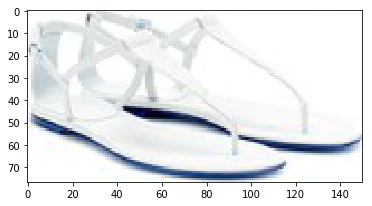

In [3]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import morphology_utils

img = cv2.imread("../data/shoe_images/30775695.jpg")
morphology_utils.plot_image(img)

In [4]:
pnts = morphology_utils.shape_points(img, nsteps=30)
# 30 points from the upper, low right and left "edges" of the shoe -> 120 points
print len(pnts)
print pnts

120
[(10, 4), (4, 6), (2, 9), (2, 11), (0, 14), (0, 16), (0, 19), (3, 21), (2, 24), (2, 26), (2, 29), (2, 31), (2, 34), (2, 36), (3, 39), (2, 41), (2, 44), (1, 46), (1, 49), (1, 51), (7, 54), (12, 56), (18, 59), (16, 61), (30, 64), (34, 66), (41, 69), (46, 71), (58, 74), (73, 76), (85, 4), (87, 6), (89, 9), (91, 11), (94, 14), (98, 16), (102, 19), (103, 21), (108, 24), (110, 26), (113, 29), (115, 31), (118, 34), (120, 36), (123, 39), (125, 41), (125, 44), (130, 46), (139, 49), (144, 51), (145, 54), (149, 56), (148, 59), (148, 61), (145, 64), (114, 66), (116, 69), (115, 71), (113, 74), (104, 76), (5, 5), (10, 4), (15, 4), (20, 6), (25, 7), (30, 0), (35, 0), (40, 2), (45, 1), (50, 0), (55, 5), (60, 9), (65, 9), (70, 6), (75, 3), (79, 2), (84, 3), (89, 9), (94, 13), (99, 17), (104, 23), (109, 26), (114, 28), (119, 35), (124, 40), (129, 46), (134, 47), (139, 48), (144, 51), (149, 55), (5, 53), (10, 55), (15, 58), (20, 61), (25, 61), (30, 64), (35, 66), (40, 68), (45, 70), (50, 72), (55, 73

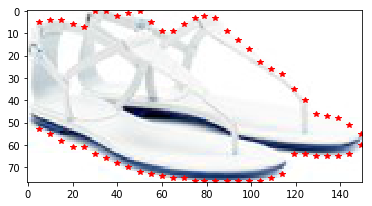

In [5]:
# Let's plot the points found when moving horizontally across the image
morphology_utils.plot_shape(img, 'x', nsteps=30)

let's calculate the distance and angle matrices

In [6]:
def distM(x):
    # x are the points
    result = np.zeros((len(x), len(x)))
    for i in xrange(len(x)):
        for j in xrange(len(x)):
            result[i,j] = euclid_distance(x[i],x[j])
    return result

def angleM(x):
    # x are the points
    result = np.zeros((len(x), len(x)))
    for i in xrange(len(x)):
        for j in xrange(len(x)):
            result[i,j] = get_angle(x[i],x[j])
    return result

In [9]:
# Compute the distance distance matrix and normalize by th mean
dm = distM(pnts)
mean_dist = dm.mean()
dm = dm / mean_dist

# radial bins:
r_bin_edges = radial_edges(r_inner,r_outer,nbins_r)
print [round(r,4) for r in r_bin_edges]

# Compute the matrix of labels depending on the location of the points within the radial bins
r_bin_matrix = np.zeros((len(pnts),len(pnts)), dtype=int)
for r in range(nbins_r):
    r_bin_matrix +=  (dm < r_bin_edges[r])

# boolean indicating points within the region of interest as defined by the radial bins
r_bool = r_bin_matrix > 0

print r_bin_matrix

[0.125, 0.2276, 0.4143, 0.7543, 1.3732, 2.5]
[[6 6 5 ..., 1 1 1]
 [6 6 6 ..., 1 1 1]
 [5 6 6 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 6 6 5]
 [1 1 1 ..., 6 6 6]
 [1 1 1 ..., 5 6 6]]


The distance matrix is obviously symmetric, so at this point one might wonder why don't we use [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) with scipy or just keep the upper triangle matrix. This is a fair question and it will be answered just below :) . Let's first compute the angle matrix.

In [8]:
# angular matrix
am = angleM(pnts)
# Ensure all angles are between 0 and 2Pi
am_pi = am + 2*math.pi * (am < 0)
# from angle value to angle bin
a_bin_matrix = (1 + np.floor(am_pi /(2 * math.pi / nbins_theta))).astype('int')

print a_bin_matrix

[[ 1  6  5 ...,  1  1  1]
 [12  1  5 ...,  1  1  1]
 [11 11  1 ...,  1  1  1]
 ..., 
 [ 7  7  7 ...,  1 12 12]
 [ 7  7  7 ...,  6  1 11]
 [ 7  7  7 ...,  6  5  1]]


As mentioned before, the distance matrix is symmetric. To speed the processing and avoid repetition we might consider computing the shape matrix using just the upper triangle. However, the angle matrix is not strictly symmetric. This is, $angle(point1,point2)$ is $\pi + angle(point1,point2)$. Therefore, since we use 12 theta bins, a rotation by $\pi$ degrees corresponds to 6 bins. This means that points in the lower triangle matrix are equal to points in the upper triangle matrix $\pm$6 depending on their relative location.

Let's have a look:

In [9]:
print a_bin_matrix[0, 1:] #angle of the 1st point relative to all points in pnts
print a_bin_matrix[1:, 0] #angle of all points relative to the 1st point in pnts

[ 6  5  5  5  5  5  4  4  4  4  4  4  4  4  4  4  4  4  4  4  3  3  3  3  3
  3  3  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  2  2  2  6  1  1  1  1 12 12 12 12 12  1  1  1  1 12 12
 12  1  1  1  1  1  1  1  1  1  1  1  1  1  4  4  3  3  3  3  3  3  3  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1]
[12 11 11 11 11 11 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9  9  9  9  9
  9  9  8  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  8  8  8  8  8 12  1  7  7  7  6  6  6  6  6  7  7  7  7  6  6
  6  7  7  7  7  7  7  7  7  7  7  7  7  7 10 10  9  9  9  9  9  9  9  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  7  7  7  7  7  7  7]


We found that preserving this information yielded better results. Therefore, for convenience (and to keep the code readable), rather than using only the upper triangle matrix for distances and the entire matrix for angles, we decided the keep the entire matrix for the two metrics. Once this is clarified, lets compute the Shape Context Matrix!

In [10]:
# We will "flatten" the matrix so the end result is a 120*6*12 vector with the shape of the image encoded.
# For visualization purposes, let's also keep a 3D matrix with all the shape context matrix per point in pnts. 

# Bin Histogram
BH  = np.zeros(len(pnts)*nbins)

# Shape Context Matrix
SCM = np.zeros((len(pnts), nbins_r, nbins_theta))

for i in range(len(pnts)):
    sm = np.zeros((nbins_r, nbins_theta))
    for j in range(len(pnts)):
        if (r_bool[i, j]):
            sm[r_bin_matrix[i, j] - 1, a_bin_matrix[i, j] - 1] += 1
            SCM[i,:,:] = sm
    BH[i*nbins:i*nbins+nbins] = sm.reshape(nbins)

ok, so let's visualise and interpret the results for, for example, the first point:

Populating the interactive namespace from numpy and matplotlib
(10, 4)


`%matplotlib` prevents importing * from pylab and numpy


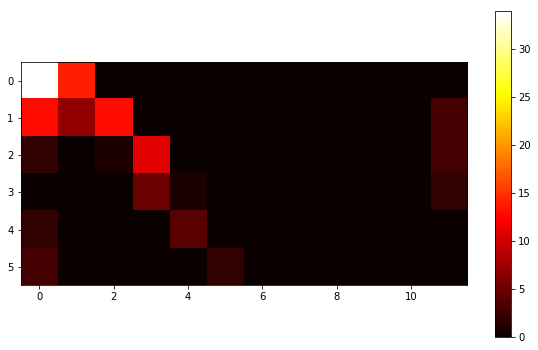

In [11]:
import pylab
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

print pnts[0]
plt.imshow(SCM[0,:,:],cmap="hot")
plt.colorbar()
plt.show()

Let's have a look to the binned matrices to understand this plot.

In [12]:
print r_bin_matrix[0,:]
print a_bin_matrix[0,:]

[6 6 5 5 5 5 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 5 5 4 4 3 3 3 3 3 2 2
 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 3 3 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
[ 1  6  5  5  5  5  5  4  4  4  4  4  4  4  4  4  4  4  4  4  4  3  3  3  3
  3  3  3  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  2  2  2  2  2  6  1  1  1  1 12 12 12 12 12  1  1  1  1 12
 12 12  1  1  1  1  1  1  1  1  1  1  1  1  1  4  4  3  3  3  3  3  3  3  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1]


So, what this plot is telling us is that, relative to the first point, the number of points that fall within the outer radial bin (corresponding to radial label 1) and the first angular bin (corresponding to angular lable 1), i.e. top right corner of the map, is 34.

In [13]:
len(np.intersect1d(np.where(a_bin_matrix[0,:] == 1)[0], np.where(r_bin_matrix[0,:] == 1)[0]))

34

[(124, 64), (50, 72), (116, 69), (40, 2), (25, 7), (84, 3), (2, 24), (104, 23), (145, 64)]


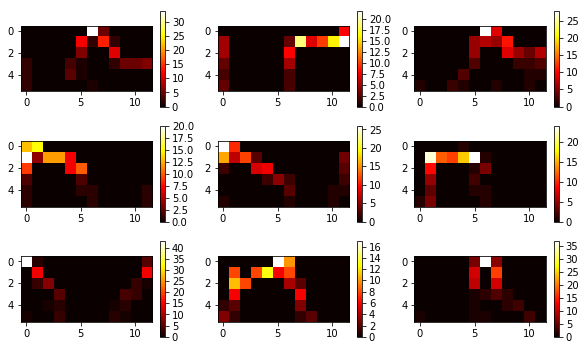

In [14]:
# let's pick a few points at random and see how the plots look
from random import randint

idx = [randint(0, len(pnts)) for _ in range(9)]
slices = [SCM[i,:,:] for i in idx]
print [pnts[i] for i in idx]

plt.figure()
for i,sl in enumerate(slices):
    plt.subplot(3,3,i+1)
    plt.imshow(sl,cmap="hot")
    plt.colorbar()
plt.show()

And that's it. Now all this plots are flattened and concatenated and we cluster them using k-means in the hope that the shapes cluster relatively well. 